In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import scipy
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import merge
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Input, Softmax, Activation, Flatten
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import optimizers
from keras.layers import concatenate,AveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import pandas as pd
import numpy as np
import os
import cv2
from glob import glob
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.preprocessing import image as k_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
print(os.listdir('dataset-master'))
print(os.listdir('dataset2-master'))

Using TensorFlow backend.


['.DS_Store', 'Annotations', 'JPEGImages', 'labels.csv']
['.DS_Store', 'images', 'labels.csv']


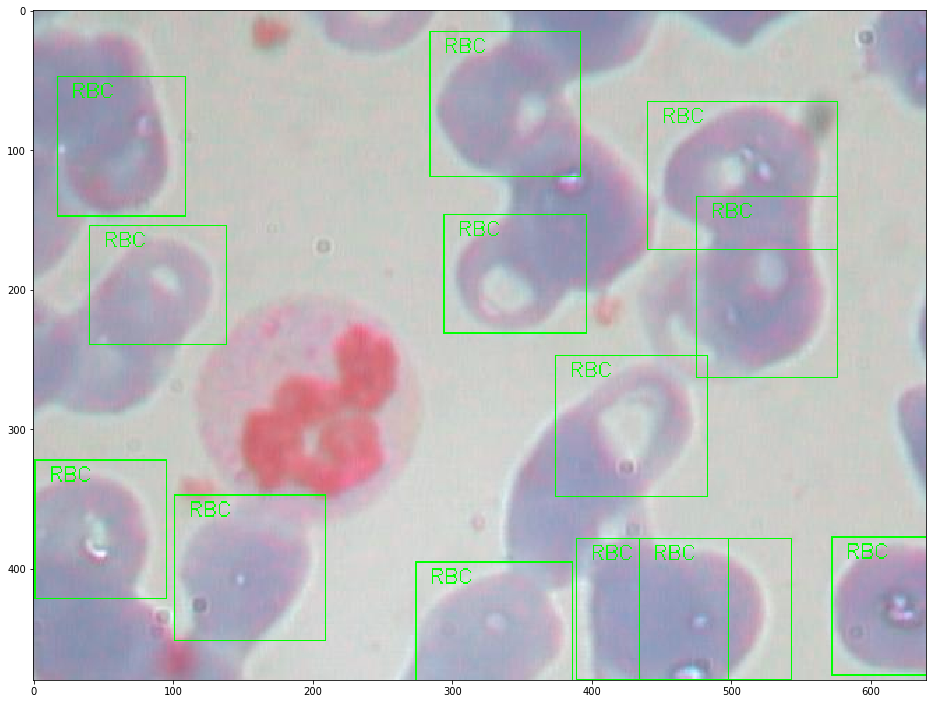

In [2]:
image = cv2.imread("dataset-master/JPEGImages/BloodImage_00022.jpg")
tree = ET.parse("dataset-master/Annotations/BloodImage_00022.xml")
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

def get_training_generator(batch_size=8):
    train_data_dir = 'dataset2-master/images/TRAIN/'
    validation_data_dir = 'dataset2-master/images/TEST/'
    #image_datagen = CustomImageDataGenerator(featurewise_center=True)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size
    )

    val_generator = train_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False
    )

    return train_generator, val_generator

In [4]:
def rgb_to_grayscale(input):
    """Average out each pixel across its 3 RGB layers resulting in a grayscale image"""
    return K.mean(input, axis=3)

In [5]:
def rgb_to_grayscale_output_shape(input_shape):
    return input_shape[:-1]


batch_size_phase_one = 8
batch_size_phase_two = 8
nb_val_samples = 1000

nb_epochs = 10

img_width = 299
img_height = 299

In [6]:
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras.engine import Input
from keras.layers import GlobalAveragePooling2D, Dense, Reshape, Lambda, K, LSTM
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import merge
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
import time
import numpy as np

np.random.seed(1337)
# Loading dataset
print("Loading the dataset with batch size of {}...".format(batch_size_phase_one))
train_generator, val_generator = get_training_generator(batch_size_phase_one)
print("Dataset loaded")

print("Building model...")
input_tensor = Input(shape=(img_width, img_height, 3))

# Creating CNN
cnn_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)

x = cnn_model.output
cnn_bottleneck = GlobalAveragePooling2D()(x)

# Make CNN layers not trainable
for layer in cnn_model.layers:
    layer.trainable = False

# Creating RNN
x = Lambda(rgb_to_grayscale, rgb_to_grayscale_output_shape)(input_tensor)
x = Reshape((23, 3887))(x)  # 23 timesteps, input dim of each timestep 3887
x = LSTM(2048, return_sequences=True)(x)
rnn_output = LSTM(2048)(x)

Loading the dataset with batch size of 8...
Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Dataset loaded
Building model...


In [ ]:
from keras.callbacks import TensorBoard
# Merging both cnn bottleneck and rnn's output wise element wise multiplication
x = concatenate([cnn_bottleneck, rnn_output])
predictions = Dense(4, activation='softmax')(x)

model = Model(input=input_tensor, output=predictions)

print("Model built")

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

print("Starting training")
#checkpointer = ModelCheckpoint(filepath="./initial_cnn_rnn_weights_2.hdf5", verbose=1, save_best_only=True)
model.fit_generator(train_generator, samples_per_epoch=4480, nb_epoch=nb_epochs, verbose=1,validation_data=val_generator,nb_val_samples=nb_val_samples)

print("Initial training done, starting phase two (finetuning)")

# Load two new generator with smaller batch size, needed because using the same batch size
# for the fine tuning will result in GPU running out of memory and tensorflow raising an error
print("Loading the dataset with batch size of {}...".format(batch_size_phase_two))
train_generator, val_generator = get_training_generator(batch_size_phase_two)
print("Dataset loaded")

# Load best weights from initial training
model.load_weights("./initial_cnn_rnn_weights_2.hdf5")

# Make all layers trainable for finetuning
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

#checkpointer = ModelCheckpoint(filepath="./finetuned_cnn_rnn_weights_2.hdf5", verbose=1, save_best_only=True,
                              # monitor='val_acc')
model.fit_generator(train_generator, samples_per_epoch=540, nb_epoch=nb_epochs, verbose=1, validation_data=val_generator,nb_val_samples=nb_val_samples)

# Final evaluation of the model
print("Training done, doing final evaluation...")

model.load_weights("./finetuned_cnn_rnn_weights_2.hdf5")

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',metrics=['accuracy', 'top_k_categorical_accuracy'])

scores = model.evaluate_generator(val_generator, val_samples=nb_val_samples)
print(model.metrics_names, scores)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

c:\users\aditya\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  


Model built
Starting training


c:\users\aditya\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
c:\users\aditya\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_steps=1000, epochs=10, verbose=1, steps_per_epoch=560, validation_data=<keras_pre...)`
  


Epoch 1/10
 34/560 [>.............................] - ETA: 3:17:46 - loss: 5.1562